In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from azureml.core import Dataset, Datastore, Workspace
from azureml.data.datapath import DataPath
import sys

In [3]:
df = pd.read_csv('imbalanced_class_df.csv')
df.head()

,gw_mac_address,mobile_phones_count,computer_count,tablet_count,other_count,smarthome_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,...,traffic_rx_bucket,pod_count,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,dls_score_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,has_pod
0,98d2dc8fa082ac832d6c341531f4f84a63fabd9d96510f...,0,0,0,1,0,0,0,0,0,...,1,1,2,1,0,5,5,1,0,1
1,20763e4fa0839e5b4d6172be0cb974b896b7cfff987430...,2,3,1,14,0,0,0,3,1,...,3,1,1,1,1,0,3,1,1,1
2,51452b9bb13e5bd00e44baaf8850194bc2a5ea79382d3a...,2,0,1,11,4,0,0,1,1,...,3,1,1,1,2,0,3,2,1,1
3,b40d4a53936da79d89c2d4cd481097b631e2284031aaac...,1,1,0,2,0,0,0,1,1,...,1,1,1,1,1,0,4,1,1,1
4,6bade1d9f4b44491c1e5444b6d6251e0b885bdd3219727...,7,5,0,4,1,0,0,0,1,...,5,1,1,1,2,0,2,1,1,1


In [4]:
df.columns

Index(['gw_mac_address', 'mobile_phones_count', 'computer_count',
       'tablet_count', 'other_count', 'smarthome_count', 'wearables_count',
       'gaming_count', 'tv_&_audio_count', 'printer_&_scanners_count',
       'network_count', 'home_network_type', 'traffic_tx_bucket',
       'traffic_rx_bucket', 'pod_count', 'speed_tier_bucket',
       'interference_24G_bucket', 'interference_5G_bucket', 'dls_score_bucket',
       'WEM_bucket', 'RSSI_bucket_24G', 'RSSI_bucket_5G', 'has_pod'],
      dtype='object')

In [5]:
print('Unique Customers in this data are {} in a data of {}'.format(df['gw_mac_address'].nunique(), len(df)))
print('There are {} with extender Pods which is {}% of all customers'.format(df['has_pod'].sum(), (df['has_pod'].sum()/len(df)*100)))

Unique Customers in this data are 20627 in a data of 20627
There are 1862 with extender Pods which is 9.027003442090464% of all customers


In [6]:
type_of_device = ['mobile_phones_count', 'computer_count',
       'tablet_count', 'other_count', 'smarthome_count', 'wearables_count',
       'gaming_count', 'tv_&_audio_count', 'printer_&_scanners_count',
       'network_count', ]
technical_aspects = ['home_network_type', 'traffic_tx_bucket',
       'traffic_rx_bucket', 'pod_count', 'speed_tier_bucket',
       'interference_24G_bucket', 'interference_5G_bucket', 'dls_score_bucket',
       'WEM_bucket', 'RSSI_bucket_24G', 'RSSI_bucket_5G',]

###################################################################################################
###Notes 
number of devices can be adding all the devices
without Smart homes might be a significant factor
Without wearables
Without gaming
without tv_&_audio_count  


In [7]:
table = pd.pivot_table(df, values='has_pod', index=[],
                    columns=['computer_count'], aggfunc=np.sum)
table

computer_count,0,1,2,3,4,5,6,7,8,9,10,11,12,19
has_pod,623,566,385,171,63,27,14,7,3,1,0,1,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20627 entries, 0 to 20626
Data columns (total 23 columns):
gw_mac_address              20627 non-null object
mobile_phones_count         20627 non-null int64
computer_count              20627 non-null int64
tablet_count                20627 non-null int64
other_count                 20627 non-null int64
smarthome_count             20627 non-null int64
wearables_count             20627 non-null int64
gaming_count                20627 non-null int64
tv_&_audio_count            20627 non-null int64
printer_&_scanners_count    20627 non-null int64
network_count               20627 non-null int64
home_network_type           20627 non-null object
traffic_tx_bucket           20627 non-null int64
traffic_rx_bucket           20627 non-null int64
pod_count                   20627 non-null int64
speed_tier_bucket           20627 non-null int64
interference_24G_bucket     20627 non-null int64
interference_5G_bucket      20627 non-null int64
dls_sco

In [9]:
df['home_network_type'].unique()

array(['Pod_Home', 'Gateway_Only'], dtype=object)

In [10]:
pd.crosstab(index=df['has_pod'], columns=df['home_network_type'],margins=True)

home_network_type,Gateway_Only,Pod_Home,All
has_pod,,,
0,18765,0,18765
1,733,1129,1862
All,19498,1129,20627


In [11]:
pd.crosstab(index=df['has_pod'], columns=df['dls_score_bucket'],margins=True)

dls_score_bucket,0,5,All
has_pod,,,
0,10053,8712,18765
1,1002,860,1862
All,11055,9572,20627


In [12]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
enc = onehotencoder.fit_transform(df['home_network_type'].values.reshape(-1,1)).toarray()
#print(enc)
#To add this back into the original dataframe 
#dfOneHot = pd.DataFrame(enc, columns = ["home_type_network_"+str(int(i)) for i in range(1,2)]) 
dfOneHot = pd.DataFrame(enc, columns = ['home_type_network_home', 'home_type_network_gateway']) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df = df.drop(['home_network_type'], axis=1) 
#printing to verify 
df.head()

,gw_mac_address,mobile_phones_count,computer_count,tablet_count,other_count,smarthome_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,...,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,dls_score_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,has_pod,home_type_network_home,home_type_network_gateway
0,98d2dc8fa082ac832d6c341531f4f84a63fabd9d96510f...,0,0,0,1,0,0,0,0,0,...,2,1,0,5,5,1,0,1,0.0,1.0
1,20763e4fa0839e5b4d6172be0cb974b896b7cfff987430...,2,3,1,14,0,0,0,3,1,...,1,1,1,0,3,1,1,1,0.0,1.0
2,51452b9bb13e5bd00e44baaf8850194bc2a5ea79382d3a...,2,0,1,11,4,0,0,1,1,...,1,1,2,0,3,2,1,1,1.0,0.0
3,b40d4a53936da79d89c2d4cd481097b631e2284031aaac...,1,1,0,2,0,0,0,1,1,...,1,1,1,0,4,1,1,1,0.0,1.0
4,6bade1d9f4b44491c1e5444b6d6251e0b885bdd3219727...,7,5,0,4,1,0,0,0,1,...,1,1,2,0,2,1,1,1,0.0,1.0


In [13]:
#df1.info()
#df[[ 'home_type_network_home', 'home_type_network_gateway']]

In [14]:
pd.crosstab(index=df['has_pod'], columns=df['WEM_bucket'],margins=True)

WEM_bucket,0,1,2,3,4,5,All
has_pod,,,,,,,
0,44,333,4637,10465,2647,639,18765
1,4,14,315,1146,344,39,1862
All,48,347,4952,11611,2991,678,20627


In [15]:
pd.crosstab(index=df['has_pod'], columns=df['dls_score_bucket'],margins=True)

dls_score_bucket,0,5,All
has_pod,,,
0,10053,8712,18765
1,1002,860,1862
All,11055,9572,20627


In [16]:
# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
df['WEM_bucket']= label_encoder.fit_transform(df['WEM_bucket']) 
df['dls_score_bucket']= label_encoder.fit_transform(df['dls_score_bucket']) 
df.head()

,gw_mac_address,mobile_phones_count,computer_count,tablet_count,other_count,smarthome_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,...,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,dls_score_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,has_pod,home_type_network_home,home_type_network_gateway
0,98d2dc8fa082ac832d6c341531f4f84a63fabd9d96510f...,0,0,0,1,0,0,0,0,0,...,2,1,0,1,5,1,0,1,0.0,1.0
1,20763e4fa0839e5b4d6172be0cb974b896b7cfff987430...,2,3,1,14,0,0,0,3,1,...,1,1,1,0,3,1,1,1,0.0,1.0
2,51452b9bb13e5bd00e44baaf8850194bc2a5ea79382d3a...,2,0,1,11,4,0,0,1,1,...,1,1,2,0,3,2,1,1,1.0,0.0
3,b40d4a53936da79d89c2d4cd481097b631e2284031aaac...,1,1,0,2,0,0,0,1,1,...,1,1,1,0,4,1,1,1,0.0,1.0
4,6bade1d9f4b44491c1e5444b6d6251e0b885bdd3219727...,7,5,0,4,1,0,0,0,1,...,1,1,2,0,2,1,1,1,0.0,1.0


In [17]:
pd.crosstab(index=df['has_pod'], columns=df['dls_score_bucket'],margins=True)

dls_score_bucket,0,1,All
has_pod,,,
0,10053,8712,18765
1,1002,860,1862
All,11055,9572,20627


In [27]:
df['device_count'] = df['mobile_phones_count'] + df['computer_count'] + df['other_count'] + df['smarthome_count']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20627 entries, 0 to 20626
Data columns (total 25 columns):
gw_mac_address               20627 non-null object
mobile_phones_count          20627 non-null int64
computer_count               20627 non-null int64
tablet_count                 20627 non-null int64
other_count                  20627 non-null int64
smarthome_count              20627 non-null int64
wearables_count              20627 non-null int64
gaming_count                 20627 non-null int64
tv_&_audio_count             20627 non-null int64
printer_&_scanners_count     20627 non-null int64
network_count                20627 non-null int64
traffic_tx_bucket            20627 non-null int64
traffic_rx_bucket            20627 non-null int64
pod_count                    20627 non-null int64
speed_tier_bucket            20627 non-null int64
interference_24G_bucket      20627 non-null int64
interference_5G_bucket       20627 non-null int64
dls_score_bucket             20627 non-n

In [28]:
y = df['has_pod']
remove = ['gw_mac_address', 'pod_count', 'has_pod','mobile_phones_count','computer_count', 'other_count', 'smarthome_count']
X = df.drop(remove, axis =1 )
#categorical = ['home_network_type']
#X = X.drop(categorical, axis =1 )
X.head()

,tablet_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,network_count,traffic_tx_bucket,traffic_rx_bucket,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,dls_score_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,home_type_network_home,home_type_network_gateway,device_count
0,0,0,0,0,0,0,1,1,2,1,0,1,5,1,0,0.0,1.0,1
1,1,0,0,3,1,0,2,3,1,1,1,0,3,1,1,0.0,1.0,19
2,1,0,0,1,1,0,3,3,1,1,2,0,3,2,1,1.0,0.0,17
3,0,0,0,1,1,0,1,1,1,1,1,0,4,1,1,0.0,1.0,4
4,0,0,0,0,1,0,2,5,1,1,2,0,2,1,1,0.0,1.0,17


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


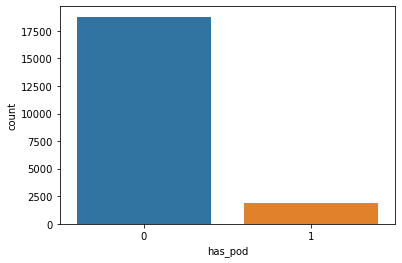

Without Pod:  1
With Pod :  0


In [29]:
ax = sns.countplot(y,label="Count")       
B, M = y.value_counts()
print('Without Pod: ', 1)
print('With Pod : ', 0)

In [30]:
X.describe()

,tablet_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,network_count,traffic_tx_bucket,traffic_rx_bucket,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,dls_score_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,home_type_network_home,home_type_network_gateway,device_count
count,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000,20627.000000
mean,0.435449,0.132836,0.129345,0.306588,0.218015,0.007224,2.992437,2.996461,1.847191,1.048965,1.130315,0.464052,2.930043,1.572114,0.969215,0.945266,0.054734,9.455859
std,0.762968,0.415217,0.397126,0.654928,0.426879,0.090765,1.413405,1.411309,1.147815,0.400508,0.706994,0.498718,0.774548,0.855435,0.172739,0.227466,0.227466,5.831578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,5.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,8.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,0.000000,12.000000
max,8.000000,6.000000,4.000000,13.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,5.000000,5.000000,1.000000,1.000000,1.000000,76.000000


In [31]:
X.info()
#X.home_network_type.dtype
# X['home_network_type'] = pd.to_numeric(X['home_network_type'], errors='coerce')
# X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20627 entries, 0 to 20626
Data columns (total 18 columns):
tablet_count                 20627 non-null int64
wearables_count              20627 non-null int64
gaming_count                 20627 non-null int64
tv_&_audio_count             20627 non-null int64
printer_&_scanners_count     20627 non-null int64
network_count                20627 non-null int64
traffic_tx_bucket            20627 non-null int64
traffic_rx_bucket            20627 non-null int64
speed_tier_bucket            20627 non-null int64
interference_24G_bucket      20627 non-null int64
interference_5G_bucket       20627 non-null int64
dls_score_bucket             20627 non-null int64
WEM_bucket                   20627 non-null int64
RSSI_bucket_24G              20627 non-null int64
RSSI_bucket_5G               20627 non-null int64
home_type_network_home       20627 non-null float64
home_type_network_gateway    20627 non-null float64
device_count                 20627 no

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

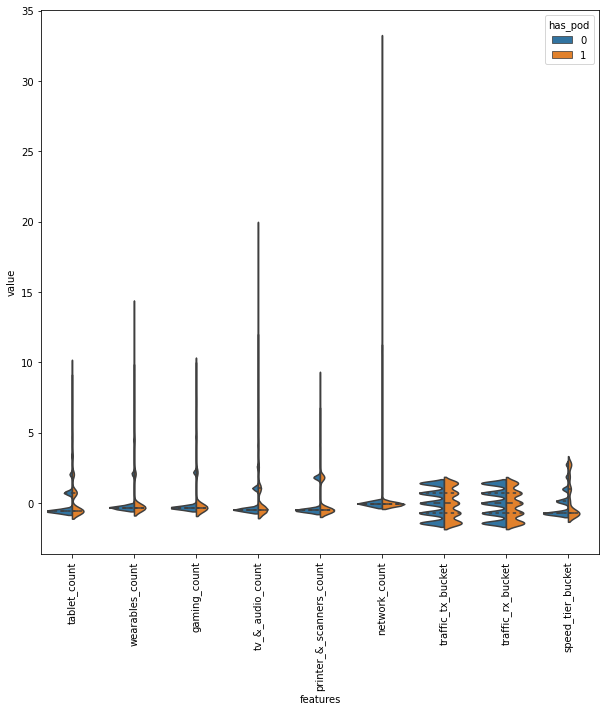

In [32]:
# first ten features
data_dia = y
data = X
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:9]],axis=1)
data = pd.melt(data,id_vars="has_pod",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="has_pod", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

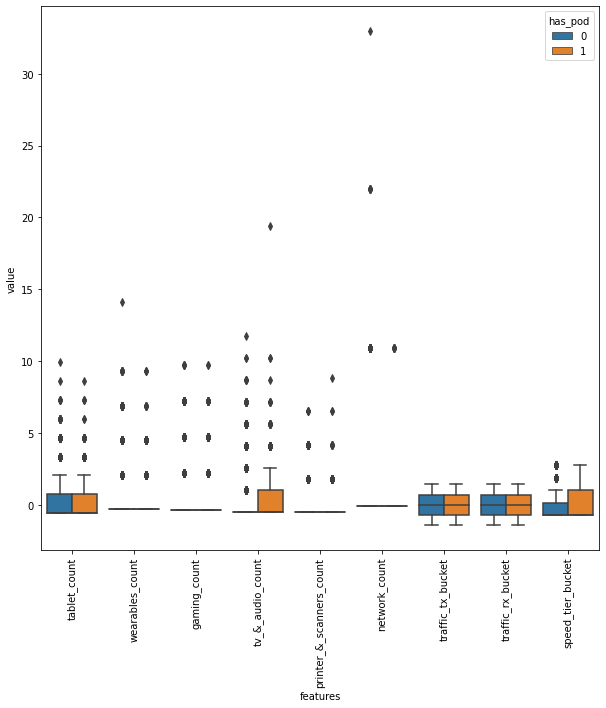

In [33]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="has_pod", data=data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

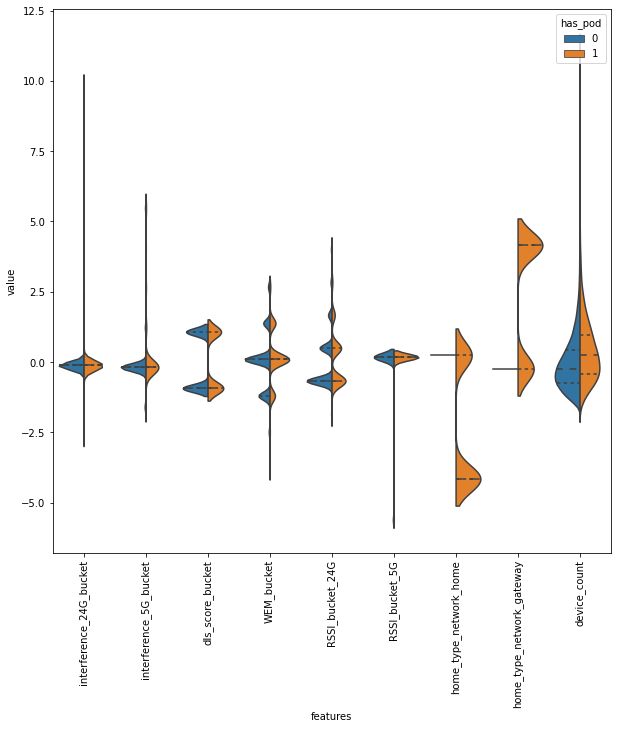

In [35]:
# Second ten features
data = pd.concat([y,data_n_2.iloc[:,9:18]],axis=1)
data = pd.melt(data,id_vars="has_pod",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="has_pod", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

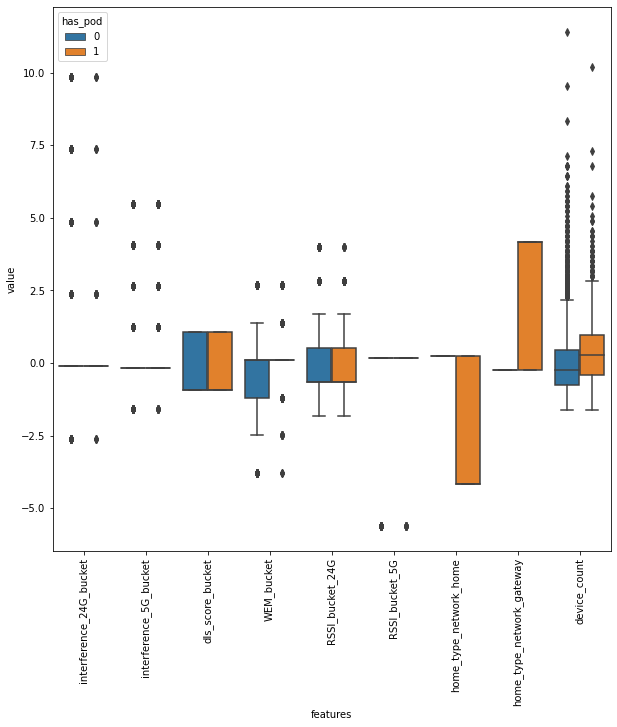

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="has_pod", data=data)
plt.xticks(rotation=90)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


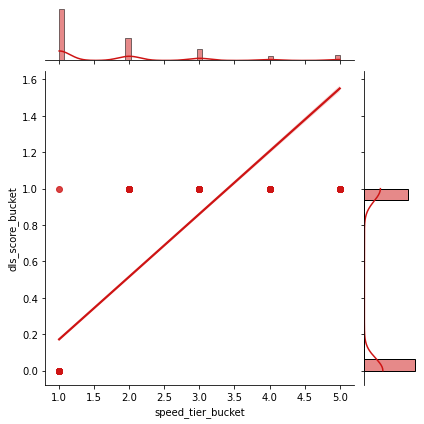

In [37]:
sns.jointplot(X.loc[:,'speed_tier_bucket'], X.loc[:,'dls_score_bucket'], kind="reg", color="#ce1414")

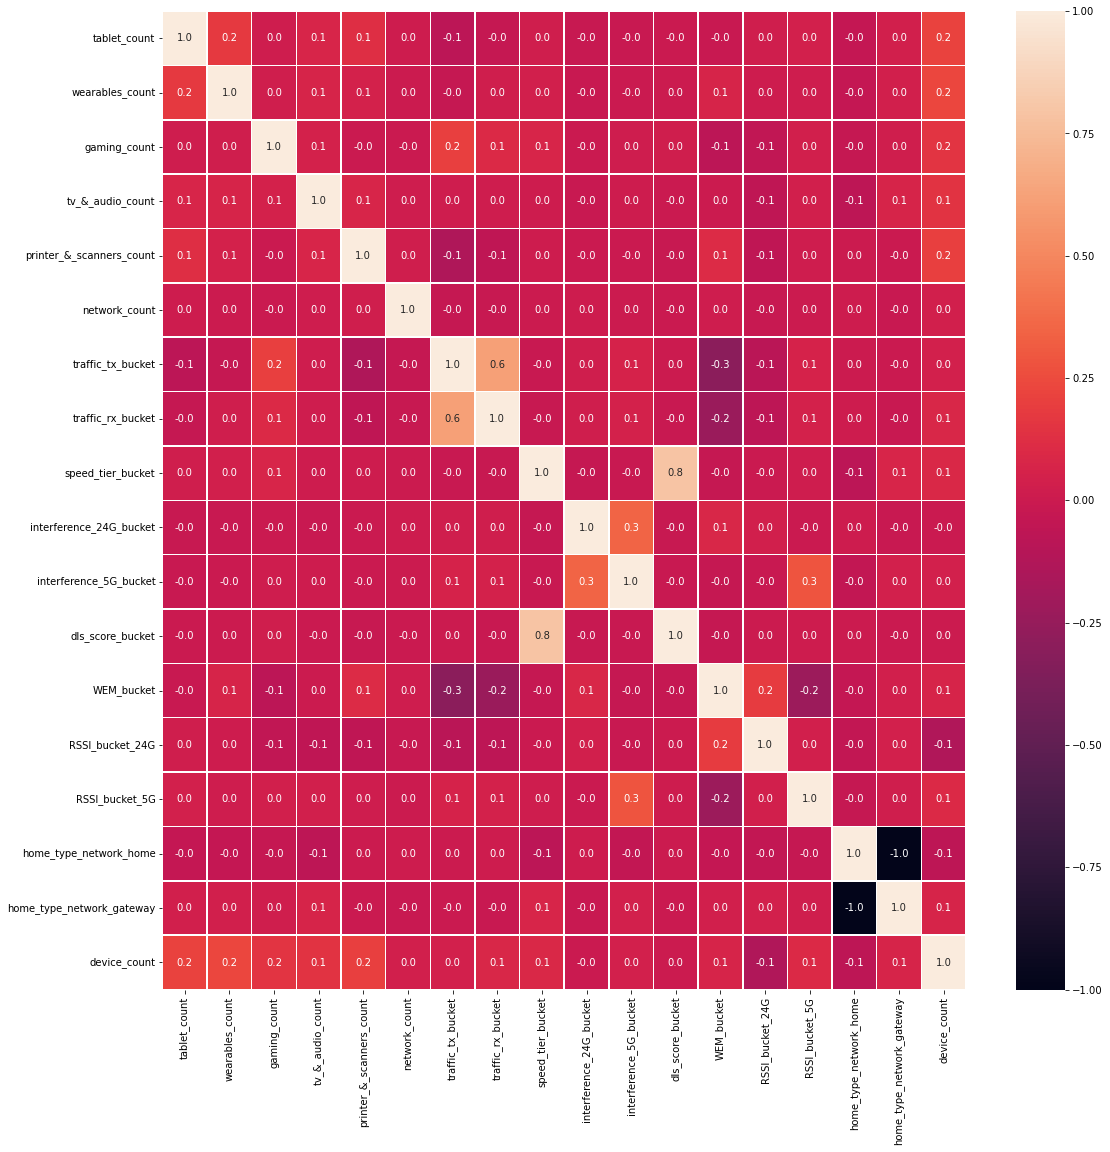

In [38]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [39]:
#pd.crosstab(index=df['has_pod'], columns=df['home_network_type'],margins=True)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20627 entries, 0 to 20626
Data columns (total 18 columns):
tablet_count                 20627 non-null int64
wearables_count              20627 non-null int64
gaming_count                 20627 non-null int64
tv_&_audio_count             20627 non-null int64
printer_&_scanners_count     20627 non-null int64
network_count                20627 non-null int64
traffic_tx_bucket            20627 non-null int64
traffic_rx_bucket            20627 non-null int64
speed_tier_bucket            20627 non-null int64
interference_24G_bucket      20627 non-null int64
interference_5G_bucket       20627 non-null int64
dls_score_bucket             20627 non-null int64
WEM_bucket                   20627 non-null int64
RSSI_bucket_24G              20627 non-null int64
RSSI_bucket_5G               20627 non-null int64
home_type_network_home       20627 non-null float64
home_type_network_gateway    20627 non-null float64
device_count                 20627 no

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


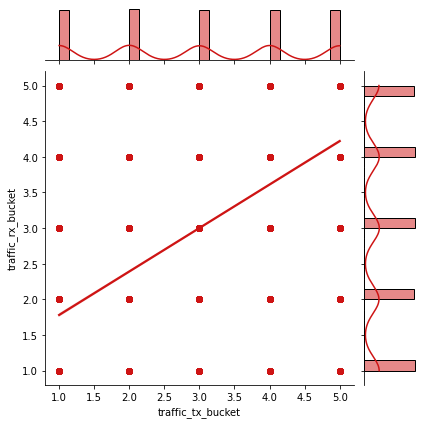

In [41]:
sns.jointplot(X.loc[:,'traffic_tx_bucket'], X.loc[:,'traffic_rx_bucket'], kind="reg", color="#ce1414")

In [42]:
#feature to be dropped 
drop_list1 = ['dls_score_bucket','traffic_rx_bucket', 'home_type_network_home']
X1 = X.drop(drop_list1,axis = 1 )        # do not modify x, we will use it later 
X1.head()

,tablet_count,wearables_count,gaming_count,tv_&_audio_count,printer_&_scanners_count,network_count,traffic_tx_bucket,speed_tier_bucket,interference_24G_bucket,interference_5G_bucket,WEM_bucket,RSSI_bucket_24G,RSSI_bucket_5G,home_type_network_gateway,device_count
0,0,0,0,0,0,0,1,2,1,0,5,1,0,1.0,1
1,1,0,0,3,1,0,2,1,1,1,3,1,1,1.0,19
2,1,0,0,1,1,0,3,1,1,2,3,2,1,0.0,17
3,0,0,0,1,1,0,1,1,1,1,4,1,1,1.0,4
4,0,0,0,0,1,0,2,1,1,2,2,1,1,1.0,17


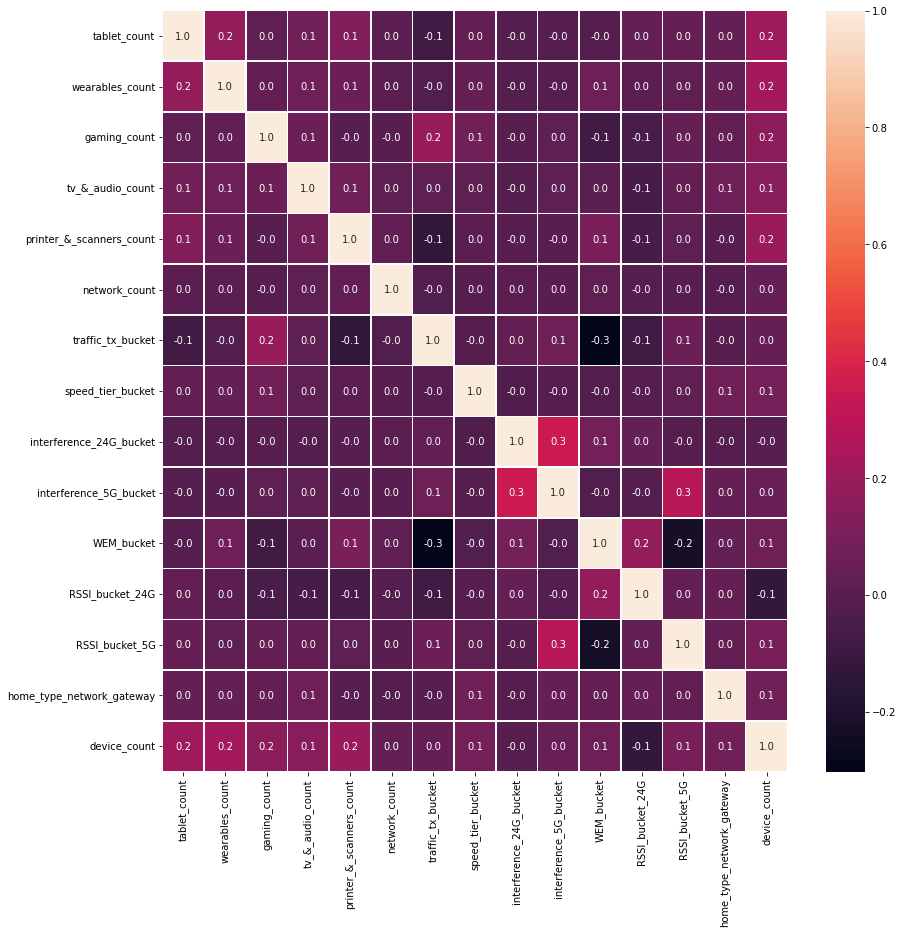

In [43]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(X1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Accuracy is:  0.9596057521408952


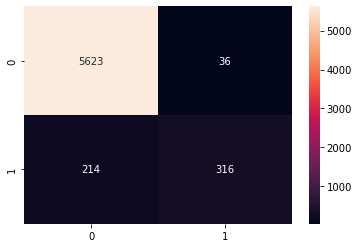

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

In [45]:
def show_metrics(y_true, y_score):
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    print("True positive: ", tp)
    print("False positive: ", fp)
    print("True negative: ", tn)
    print("False negative: ", fn)

    print("True positive rate (recall): ", tpr)
    print("False positive rate: ", fpr)
    print("Precision: ", precision)
    print("True negative rate: ", tnr)
    print("F1: ", f1)
    print("ROC-AUC: ", auc)
    print("MCC: ", mcc)

In [46]:
show_metrics(y_test, clf_rf.predict(x_test))

True positive:  316
False positive:  36
True negative:  5623
False negative:  214
True positive rate (recall):  0.5962264150943396
False positive rate:  0.006361547976674324
Precision:  0.8977272727272727
True negative rate:  0.9936384520233257
F1:  0.7165532879818595
ROC-AUC:  0.7949324335588326
MCC:  0.7126792812699884


In [47]:
def roc_auc_score(y_true, y_pred):
    unique_vals = list(np.sort(np.unique(y_pred))) + [1]
    area_under_curve = 0
    fpr_points, tpr_points = [], []
    for i, th in enumerate(unique_vals):
        y_pred_th = np.zeros(len(y_pred))
        y_pred_th[y_pred >= th] = 1.0
        
        tp = np.sum(y_test * y_pred_th)
        fp = np.sum((y_test == 0) * y_pred_th)
        tn = np.sum((y_test==0) * (y_pred_th==0))
        fn = np.sum(y_test * (y_pred_th==0))
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        fpr_points.append(fpr)
        tpr_points.append(tpr)
        
        if i > 0:
            area_under_curve += (fpr_prev - fpr) * tpr
        fpr_prev = fpr
        
    plt.figure(figsize=(5, 5), dpi=100)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    sns.lineplot(fpr_points, tpr_points)
    plt.show()
        
    return area_under_curve



/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


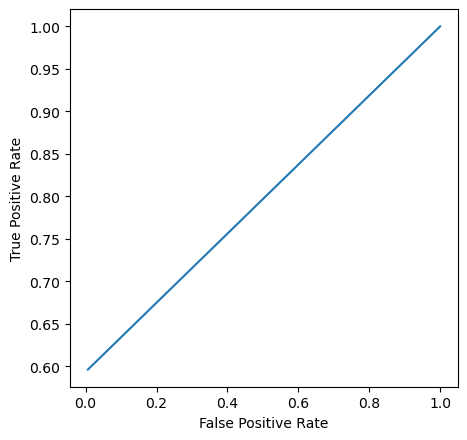

0.5924334921497564


In [48]:
print(roc_auc_score(y_test,clf_rf.predict(x_test)))

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=2,).fit(x_train, y_train)

In [50]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [9.07728245e+01 5.09597494e+01 5.99448396e+01 1.20263270e+02
 5.96654451e+00 1.30151086e+00 3.77970047e+00 8.71969922e+01
 1.93497863e-01 1.58008628e+01 4.46290498e+00 1.00130034e+01
 8.42856278e-01 8.02890090e+03 9.38458810e+02]
Feature list: Index(['tablet_count', 'wearables_count', 'gaming_count', 'tv_&_audio_count',
       'printer_&_scanners_count', 'network_count', 'traffic_tx_bucket',
       'speed_tier_bucket', 'interference_24G_bucket',
       'interference_5G_bucket', 'WEM_bucket', 'RSSI_bucket_24G',
       'RSSI_bucket_5G', 'home_type_network_gateway', 'device_count'],
      dtype='object')


Accuracy is:  0.9641299079011149


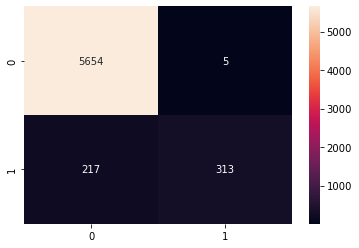

In [51]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

In [52]:
show_metrics(y_test, clf_rf_2.predict(x_test_2))

True positive:  313
False positive:  5
True negative:  5654
False negative:  217
True positive rate (recall):  0.590566037735849
False positive rate:  0.0008835483300936561
Precision:  0.9842767295597484
True negative rate:  0.9991164516699064
F1:  0.7382075471698113
ROC-AUC:  0.7948412447028776
MCC:  0.7474057130460762


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


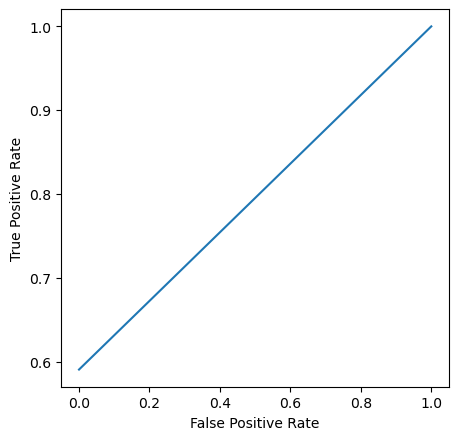

0.5900442440993975


In [53]:
print(roc_auc_score(y_test,clf_rf_2.predict(x_test_2)))

In [54]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select= 2, step=1, )
rfe = rfe.fit(x_train, y_train)



In [55]:
print('Chosen best 2 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 2 feature by rfe: Index(['home_type_network_gateway', 'device_count'], dtype='object')


Accuracy is:  0.9641299079011149


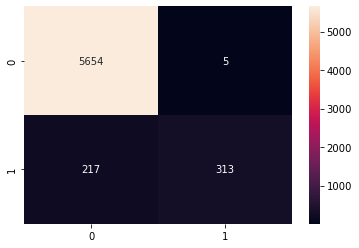

In [77]:
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_rfe = RandomForestClassifier()  
clf_rf_rfe = DecisionTreeClassifier(random_state=0)    
clr_rf_rfe = clf_rf_rfe.fit(x_train_rfe ,y_train)
ac_rfe = accuracy_score(y_test,clf_rf_rfe.predict(x_test_rfe))
print('Accuracy is: ',ac_rfe)
cm_rfe = confusion_matrix(y_test,clf_rf_rfe.predict(x_test_rfe))
sns.heatmap(cm_rfe,annot=True,fmt="d")

In [57]:
show_metrics(y_test,clf_rf_rfe.predict(x_test_rfe))

True positive:  313
False positive:  5
True negative:  5654
False negative:  217
True positive rate (recall):  0.590566037735849
False positive rate:  0.0008835483300936561
Precision:  0.9842767295597484
True negative rate:  0.9991164516699064
F1:  0.7382075471698113
ROC-AUC:  0.7948412447028776
MCC:  0.7474057130460762


In [58]:
print('Chosen best 2 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 3 feature by rfe: Index(['home_type_network_gateway', 'device_count'], dtype='object')


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


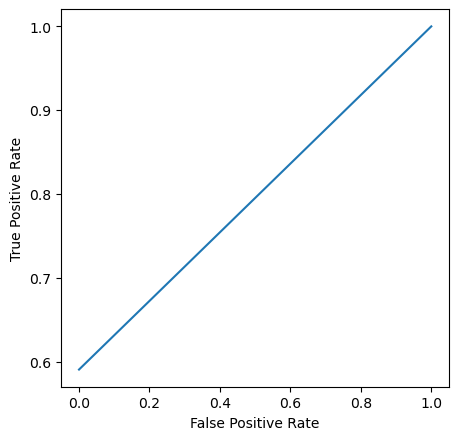

0.5900442440993975


In [59]:
print(roc_auc_score(y_test,clf_rf_rfe.predict(x_test_rfe)))

In [71]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
#clf_rf_4 =LogisticRegression()
clf_rf_4 = DecisionTreeClassifier(random_state=0)
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='balanced_accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['tablet_count', 'WEM_bucket', 'RSSI_bucket_24G',
       'home_type_network_gateway', 'device_count'],
      dtype='object')


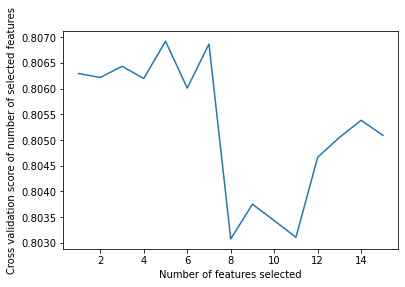

In [72]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy is:  0.9612215220552593


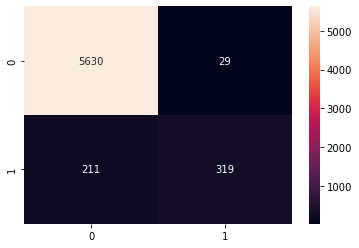

In [76]:
x_train_rfecv = rfecv.transform(x_train)
x_test_rfecv = rfecv.transform(x_test)
#random forest classifier with n_estimators=10 (default)
#clf_rf_rfecv = RandomForestClassifier()
clf_rf_rfecv = DecisionTreeClassifier(random_state=0)      
clr_rf_rfecv = clf_rf_rfecv.fit(x_train_rfecv ,y_train)
ac_rfecv = accuracy_score(y_test,clf_rf_rfecv.predict(x_test_rfecv))
print('Accuracy is: ',ac_rfecv)
cm_rfecv = confusion_matrix(y_test,clf_rf_rfecv.predict(x_test_rfecv))
sns.heatmap(cm_rfecv,annot=True,fmt="d")

In [63]:
show_metrics(y_test,clf_rf_rfecv.predict(x_test_rfecv))

True positive:  322
False positive:  57
True negative:  5602
False negative:  208
True positive rate (recall):  0.6075471698113207
False positive rate:  0.01007245096306768
Precision:  0.8496042216358839
True negative rate:  0.9899275490369324
F1:  0.7084708470847084
ROC-AUC:  0.7987373594241265
MCC:  0.6972999661897751


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


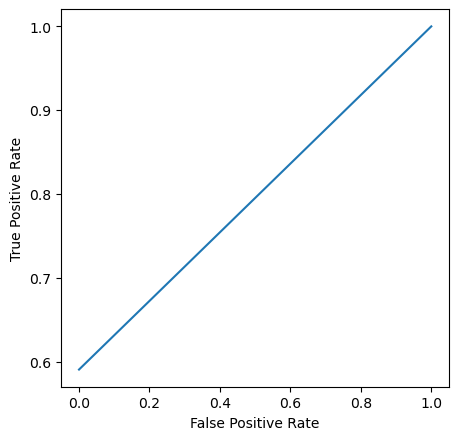

0.5901486028266878


In [75]:
print(roc_auc_score(y_test,clf_rf_rfe.predict(x_test_rfe)))

Feature ranking:
1. feature 13 (0.580486)
2. feature 14 (0.120363)
3. feature 6 (0.057352)
4. feature 7 (0.040382)
5. feature 0 (0.033289)
6. feature 11 (0.031251)
7. feature 10 (0.030838)
8. feature 3 (0.028364)
9. feature 4 (0.020958)
10. feature 2 (0.017757)
11. feature 1 (0.016706)
12. feature 9 (0.014131)
13. feature 8 (0.005242)
14. feature 5 (0.001801)
15. feature 12 (0.001079)


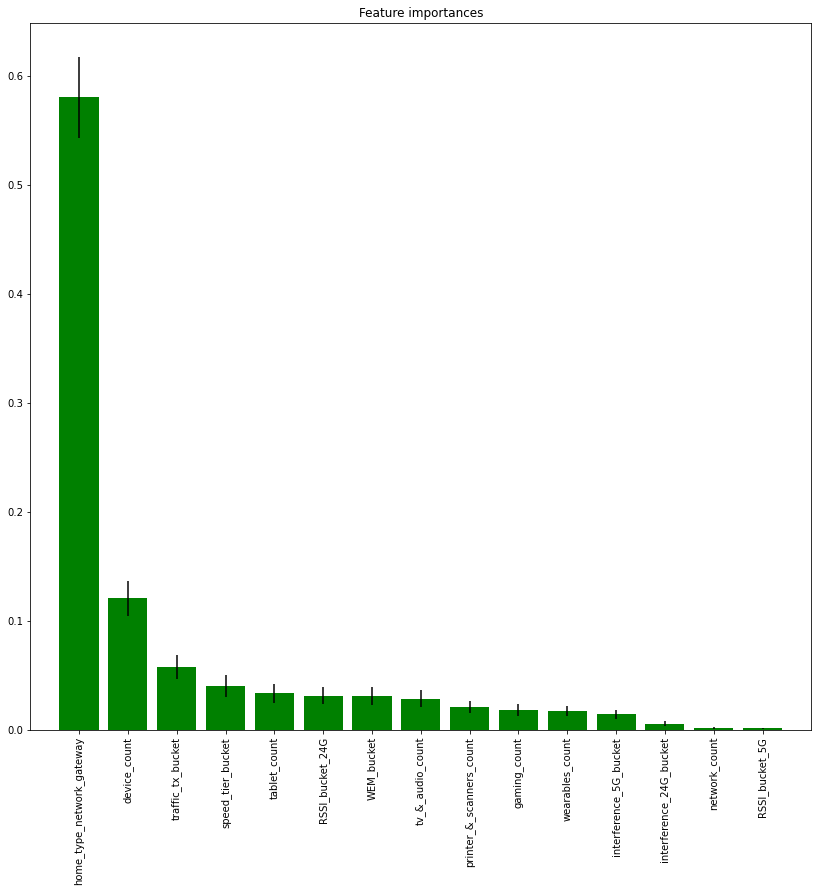

In [64]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [65]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
#logreg.fit(x_train,y_train)
logreg.fit(x_train_rfe,y_train)
#y_pred=logreg.predict(x_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy is:  0.9650993698497334


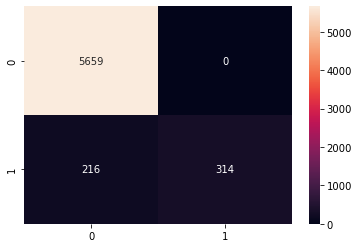

In [66]:
# ac_log = accuracy_score(y_test,logreg.predict(x_test))
# print('Accuracy is: ',ac_log)
# cm_log = confusion_matrix(y_test,logreg.predict(x_test))
# sns.heatmap(cm_log,annot=True,fmt="d")


ac_log = accuracy_score(y_test,logreg.predict(x_test_rfe))
print('Accuracy is: ',ac_log)
cm_log = confusion_matrix(y_test,logreg.predict(x_test_rfe))
sns.heatmap(cm_log,annot=True,fmt="d")

In [67]:
show_metrics(y_test,logreg.predict(x_test_rfe))

True positive:  314
False positive:  0
True negative:  5659
False negative:  216
True positive rate (recall):  0.5924528301886792
False positive rate:  0.0
Precision:  1.0
True negative rate:  1.0
F1:  0.7440758293838863
ROC-AUC:  0.7962264150943397
MCC:  0.7554275177968571


In [68]:
logreg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [69]:
logreg.coef_

array([[7.91797247, 0.07838859]])

In [70]:
#x_train_rfe = rfe.transform(x_train)
x_test_rfe

array([[ 0.,  4.],
       [ 1., 16.],
       [ 0.,  5.],
       ...,
       [ 0.,  4.],
       [ 0., 10.],
       [ 0.,  6.]])

In [78]:
len(x_test)

6189

In [82]:
y_test.has_pod.describe()

AttributeError: 'Series' object has no attribute 'has_pod'

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


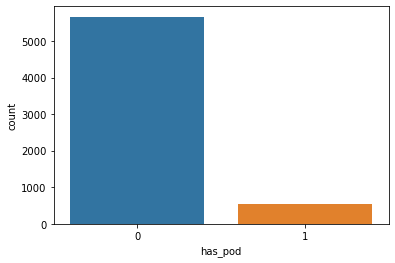

Without Pod:  1
With Pod :  0


In [83]:
ax = sns.countplot(y_test,label="Count")       
B, M = y_test.value_counts()
print('Without Pod: ', 1)
print('With Pod : ', 0)

In [84]:
M

530